In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import sys
sys.path.insert(0, '../')

import structure_model_lib
import data_utils
import paragami

import structure_optimization_lib as str_opt_lib

import preconditioner_lib

import LinearResponseVariationalBayes.ExponentialFamilies as ef

import time 


In [2]:
from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib
import cavi_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

In [3]:
np.random.seed(53453)

# Draw data

In [4]:
n_obs = 100
n_loci = 2000
n_pop = 4

# population allele frequencies
true_pop_allele_freq = np.random.random((n_loci, n_pop))

# individual admixtures
true_ind_admix_propn = np.random.dirichlet(np.ones(n_pop) / n_pop, size = (n_obs))

In [5]:
clustering_indx = data_utils.cluster_admix_get_indx(true_ind_admix_propn)
true_ind_admix_propn = true_ind_admix_propn[clustering_indx, :]

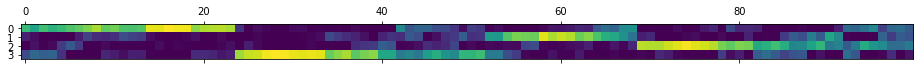

In [6]:
plt.matshow(true_ind_admix_propn.T)

In [7]:
g_obs = data_utils.draw_data(true_pop_allele_freq, true_ind_admix_propn)

In [8]:
g_obs.shape

(100, 2000, 3)

# Get prior

In [9]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_free_params = prior_params_paragami.flatten(prior_params_dict, free=True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [10]:
use_logitnormal_sticks = False

In [11]:
k_approx = 6

In [12]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [13]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx, use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (2000, 6, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (100, 5, 2) (lb=0.0, ub=inf)


## Initialize 

In [14]:
vb_params_dict = structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict, 
                                                        use_logitnormal_sticks)

In [15]:
# take a look at init 
if use_logitnormal_sticks: 
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_params_dict['ind_mix_stick_propn_mean'], 
                        vb_params_dict['ind_mix_stick_propn_info'],
                        gh_loc, gh_weights)

else: 
    # take a look at init 
    ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
    e_stick_lengths = \
            modeling_lib.get_e_beta(ind_mix_stick_beta_params)
    e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])

In [16]:
if k_approx < 6: 
    # find minimizing permutation 
    # only feasible if k_approx is small, 
    # else my computer freezes
    perm = data_utils.find_min_perm(e_pop_freq, true_pop_allele_freq, axis = 1)
else: 
    perm = np.arange(k_approx)
    
e_pop_freq = e_pop_freq[:, perm]
e_ind_admix = e_ind_admix[:, perm]

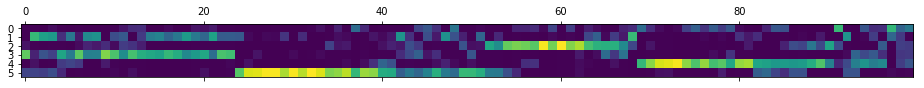

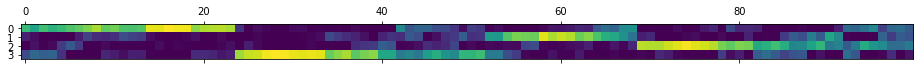

In [17]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

# Run CAVI

In [18]:
e_log_sticks, e_log_1m_sticks, \
    e_log_pop_freq, e_log_1m_pop_freq = \
        structure_model_lib.get_moments_from_vb_params_dict(g_obs, vb_params_dict, use_logitnormal_sticks)

In [20]:
e_z, stick_beta_params, pop_beta_params = \
    cavi_lib.run_cavi(g_obs, e_log_pop_freq, e_log_1m_pop_freq,
                e_log_sticks, e_log_1m_sticks,
                prior_params_dict, 
                max_iter = 500, f_tol = 1e-2)

iteration [0]; kl:3952.608162
iteration [1]; kl:3392.455286
iteration [2]; kl:3303.661196
iteration [3]; kl:3277.030543
iteration [4]; kl:3264.05157
iteration [5]; kl:3255.748158
iteration [6]; kl:3249.762555
iteration [7]; kl:3245.140411
iteration [8]; kl:3241.393956
iteration [9]; kl:3238.246244
iteration [10]; kl:3235.529129
iteration [11]; kl:3233.134617
iteration [12]; kl:3230.989707
iteration [13]; kl:3229.04276
iteration [14]; kl:3227.255823
iteration [15]; kl:3225.600129
iteration [16]; kl:3224.053327
iteration [17]; kl:3222.597673
iteration [18]; kl:3221.218805
iteration [19]; kl:3219.90488
iteration [20]; kl:3218.645959
iteration [21]; kl:3217.433569
iteration [22]; kl:3216.260393
iteration [23]; kl:3215.120061
iteration [24]; kl:3214.007007
iteration [25]; kl:3212.916375
iteration [26]; kl:3211.843963
iteration [27]; kl:3210.786181
iteration [28]; kl:3209.740023
iteration [29]; kl:3208.703039
iteration [30]; kl:3207.673314
iteration [31]; kl:3206.649453
iteration [32]; kl:32

In [21]:
vb_params_dict['pop_freq_beta_params'] = pop_beta_params
vb_params_dict['ind_mix_stick_beta_params'] = stick_beta_params

vb_free_params_cavi = vb_params_paragami.flatten(vb_params_dict, free = True)

# Get preconditioner from MFVB covariance

In [18]:
t0 = time.time()
mfvb_cov = preconditioner_lib.get_mfvb_covariance(vb_params_dict, vb_params_paragami, 
                                                  use_logitnormal_sticks = False)

print('preconditioner time: {0:03f} secs'.format(time.time() - t0))

100%|██████████| 12500/12500 [00:02<00:00, 4482.52it/s]


preconditioner time: 39.160068 secs


# Optimize with preconditioner

In [37]:
# get loss as a function of vb parameters
get_free_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=structure_model_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_free_vb_params_loss_cached = \
    lambda x : get_free_vb_params_loss(g_obs, x, prior_params_dict, 
                                       use_logitnormal_sticks)

In [38]:
init_vb_free_params = deepcopy(vb_free_params_cavi)

In [39]:
vb_opt_free_params, trust_ncg_output = \
    opt_lib.precondition_and_optimize(get_free_vb_params_loss_cached,
                                init_vb_free_params,
                                maxiter = 50, gtol = 1e-8,
                                hessian = mfvb_cov)

setting preconditioner with given Hessian: 
running newton steps
Iter 0: f = 3175.44277669
Iter 1: f = 3175.34852007
Iter 2: f = 3175.18442241
Iter 3: f = 3174.98968285
Iter 4: f = 3174.93801573
Iter 5: f = 3174.69840235
Iter 6: f = 3174.64063078
Iter 7: f = 3176.17556460
Iter 8: f = 3174.50774828
Iter 9: f = 3174.39878699
Iter 10: f = 3174.19404004
Iter 11: f = 3174.00548849
Iter 12: f = 3173.86722912
Iter 13: f = 3173.76232955
Iter 14: f = 3173.67198395
Iter 15: f = 3173.26700821
Iter 16: f = 3171.15405839
Iter 17: f = 3167.88867602
Iter 18: f = 3165.77449068
Iter 19: f = 3162.63645316
Iter 20: f = 3162.53874566
Iter 21: f = 3161.44041492
Iter 22: f = 3160.65521916
Iter 23: f = 3160.31149683
Iter 24: f = 3160.29198433
Iter 25: f = 3160.19653448
Iter 26: f = 3160.07034405
Iter 27: f = 3160.01913173
Iter 28: f = 3159.90222296
Iter 29: f = 3161.23911164
Iter 30: f = 3159.41015718
Iter 31: f = 3159.10584239
Iter 32: f = 3158.14615217
Iter 33: f = 3157.60271250
Iter 34: f = 3157.59361927


# check the hessian

In [40]:
get_kl_from_vb_free_prior_free = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

In [42]:
vb_sens = \
        vittles.HyperparameterSensitivityLinearApproximation(
            objective_fun = lambda x, y: get_kl_from_vb_free_prior_free(g_obs, x, y, 
                                                                        use_logitnormal_sticks),
            opt_par_value = vb_opt_free_params,
            hyper_par_value = prior_free_params,
            validate_optimum=False,
            hessian_at_opt=None,
            cross_hess_at_opt=None,
            factorize_hessian=True,
            hyper_par_objective_fun=None,
            grad_tol=1e-8)

In [43]:
which_prior = np.array([1., 0., 0.])
hessian_dir = str_opt_lib.check_hessian(vb_sens, which_prior)

In [44]:
np.max(np.abs(hessian_dir))

1.7905914003473784e-09